In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median
from rsi import apply as rsi

import pyfinancialdata
import trade_functions

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='24h',
    price_calculation='close',
    drop_non_price_columns=True,
)

In [3]:
# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)

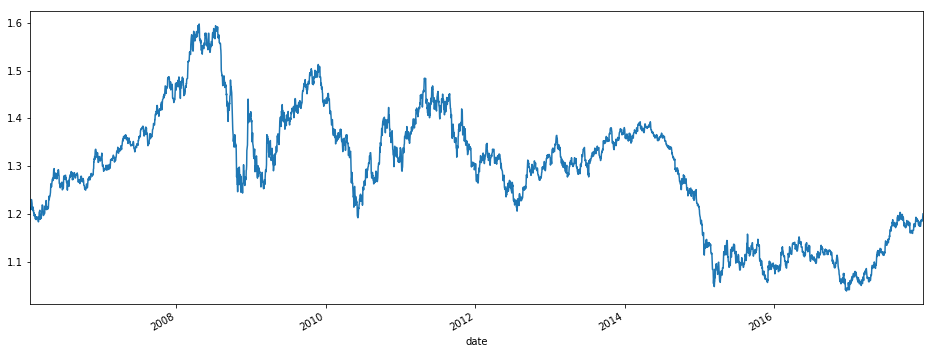

In [4]:
price_data['price'].plot(figsize=(16,6))

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 2539, test size 1270


In [6]:
episode=1000
batch_size=10

In [7]:
train_data.head(5)

,date,price,rsi
0,2006-01-17,1.2108,61.654089
1,2006-01-18,1.2107,61.523267
2,2006-01-19,1.2090,59.233980
3,2006-01-20,1.2134,63.047068
4,2006-01-22,1.2167,65.630385


In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: -965 pips, median trade count: 126
....................
episode: 40/1000
median profit: 780 pips, median trade count: 166
....................
episode: 60/1000
median profit: 870 pips, median trade count: 186
....................
episode: 80/1000
median profit: 1889 pips, median trade count: 205
....................
episode: 100/1000
median profit: 2081 pips, median trade count: 212
....................
episode: 120/1000
median profit: 2354 pips, median trade count: 209
....................
episode: 140/1000
median profit: 2459 pips, median trade count: 209
....................
episode: 160/1000
median profit: 2837 pips, median trade count: 209
....................
episode: 180/1000
median profit: 3394 pips, median trade count: 207
....................
episode: 200/1000
median profit: 3573 pips, median trade count: 207
....................
episode: 220/1000
median profit: 3901 pips, median trade count: 207
....................
epis

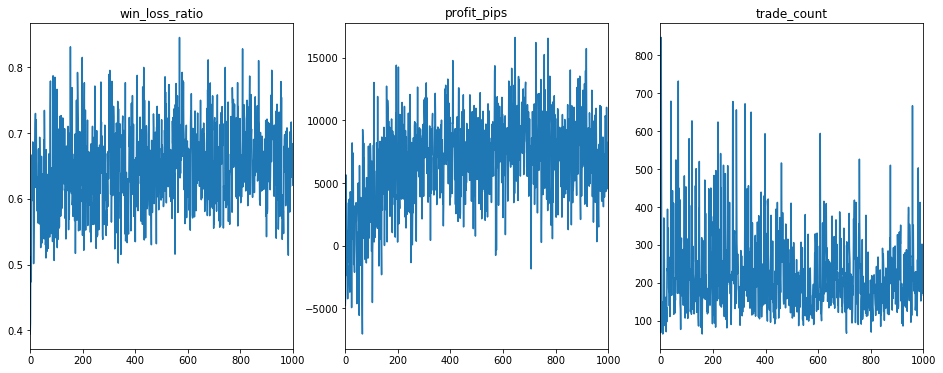

In [10]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [11]:
joblib.dump(agent, 'trained-model-24h-spread.pkl') 

['trained-model-24h-spread.pkl']

## Test

In [12]:
# Uncomment to load agent from file 
# agent = joblib.load('trained-model-24h-spread.pkl')  

In [13]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [14]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [15]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 1959.6749999998874 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134fed510>]],
      dtype=object)

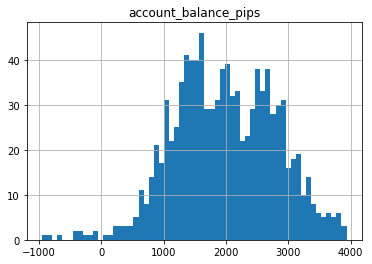

In [16]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [17]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [18]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [19]:
env._stats()

{'trade_count': 283,
 'win_loss_ratio': 0.5512367491166078,
 'account_balance': 0.31872499999998727,
 'unrealised_pl': 0}

In [20]:
position_data = env.price_data.copy()

In [21]:
position_data['position'] = position_data['position'] - 1

In [22]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

284 positions to plot...


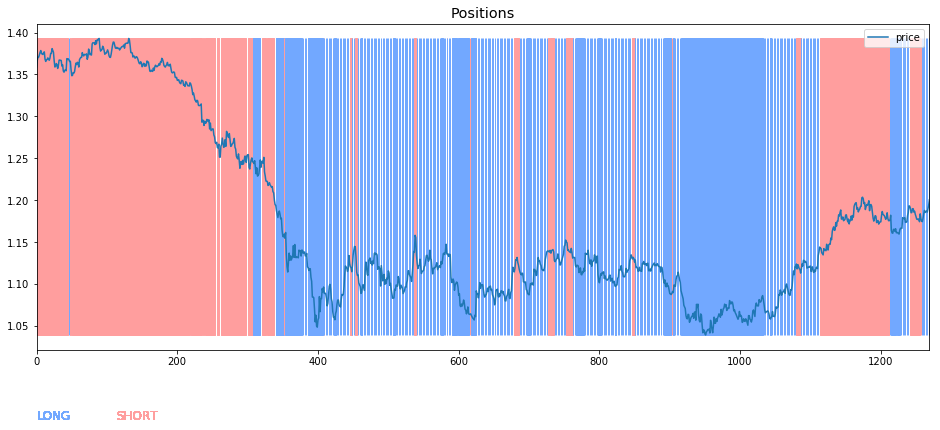

In [23]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [24]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 55.28%
Ratio of long to short positions: 8.43
Median profit: 0.0
Total profit: 0.33995000000000064
Median position length: 1.0
Number of trades: 284


In [25]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2013-12-04,1.35852,2013-12-05,1.36690,1,NaN,NaN,False,NaN
1,2013-12-05,1.36690,2014-01-27,1.36742,45,-1.0,-0.00052,False,-0.00052
2,2014-01-27,1.36742,2014-01-28,1.36542,1,1.0,-0.00200,False,-0.00252
3,2014-01-28,1.36542,2014-01-31,1.34854,3,-1.0,0.01688,True,0.01436
4,2014-01-31,1.34854,2014-02-02,1.34876,1,1.0,0.00022,True,0.01458
...,...,...,...,...,...,...,...,...,...
279,2017-12-18,1.17839,2017-12-19,1.18374,1,1.0,0.00535,True,0.33078
280,2017-12-20,1.18774,2017-12-21,1.18524,1,1.0,-0.00250,False,0.32828
281,2017-12-22,1.18617,2017-12-25,1.18711,1,1.0,0.00094,True,0.32922
282,2017-12-26,1.18574,2017-12-27,1.19004,1,1.0,0.00430,True,0.33352


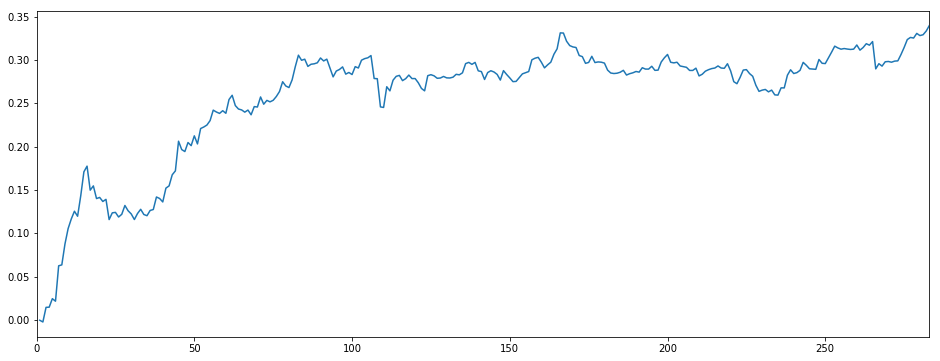

In [26]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.07367999999999963


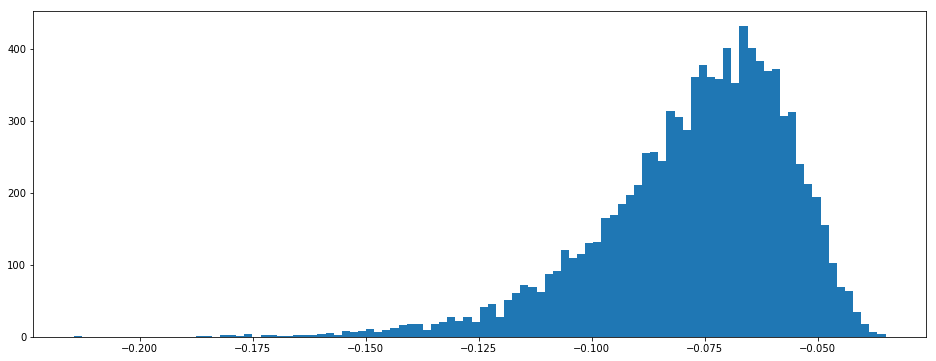

In [27]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);